<small><i>This notebook was put together by [Anderson Banihirwe](andersy005.github.io) as part of [2017 CISL/SIParCS Research Project](https://github.com/NCAR/PySpark4Climate): **PySpark for Big Atmospheric & Oceanic Data Analysis**</i></small>

<h1 align="center"> El Niño 3.4 Index Calculation </h1>

# Table of Contents

- [Introduction](#Introduction)
- [Import Packages](#Import-Packages)
- [First setup our PySpark Session and customize our configuration](#First-setup-our-PySpark-Session-and-customize-our-configuration)
- [Data](#Data)
- [RDD creation with H5Spark](#RDD-creation-with-H5Spark)
- [Global mean Temperature Calculation and plotting](#Global-mean-Temperature-Calculation-and-plotting)
- [From Spark RDD to Pandas DataFrame](#From-Spark-RDD-to-Pandas-DataFrame)
- [Compute the monthly means for each month](#Compute-the-monthly-means-for-each-month)

- [Compute the anomalies by finding the row-wise difference](#Compute-the-anomalies-by-finding-the-row-wise-difference)
- [Compute the 3 month running mean for the anomalies](#Compute-the 3-month-running-mean-for-the-anomalies)

# Introduction

This notebook will introduce **El Niño Index Calculation ** using PySpark to parallelize a number of tasks like computation of monthly averages for a given grid chunk, etc. 

NOAA's operational definitions of El Niño and La Niña conditions are based upon the Oceanic Niño Index [ONI]. The ONI is defined as the 3-month running means of SST anomalies in the Niño 3.4 region [5N-5S, 120-170W]. 

## Computational Recipe:

- Compute area averaged total SST from Niño 3.4 region.
- Compute monthly climatology (1854 - 2016) for area averaged total SST from Niño 3.4 region, and subtract climatology from area averaged total SST time series to obtain anomalies.
- Smooth the anomalies with a 3-month running mean.


# Import Packages

In [2]:
# Hide warnings if there are any
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession
from pyspark import SparkConf
import read
import numpy as np
from __future__ import print_function
import h5py
from glob import glob
import pandas as pd

%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import os
import sys
import cf_units as cf

# First setup our PySpark Session and customize our configuration

In [3]:
spark = SparkSession.builder.appName("el-nino-index").getOrCreate()

spark.conf.set('spark.serializer', 'org.apache.spark.serializer.KryoSerializer')
spark.conf.set('spark.Kryoserializer.buffer.max.mb', 1024)
spark.conf.set('spark.driver.memory', '15g')
spark.conf.set('spark.executor.memory', '6g')
spark.conf.set('spark.driver.maxResultSize', '4g')
spark.conf.set('spark.executor.cores', 2)
spark.conf.set('spark.speculation', True)

In [4]:
sc = spark.sparkContext
sc.addPyFile("/glade/p/work/abanihi/h5spark/src/main/python/h5spark/read.py")

In [5]:
# Print some information about Spark's configuration
print(SparkConf().toDebugString())

spark.Kryoserializer.buffer.max.mb=4096
spark.app.name=el-nino-index
spark.driver.maxResultSize=10g
spark.driver.memory=20g
spark.executor.memory=15g
spark.master=spark://r1i0n21:7077
spark.serializer=org.apache.spark.serializer.KryoSerializer
spark.speculation=True
spark.submit.deployMode=client


# Data

[**NCEP Version 2.0 OI Global SST and NCDC Version 4.0 Extended Reconstructed SST Analyses**](https://rda.ucar.edu/datasets/ds277.0/)

In this particular case, **the NCDC ERSST Version 4** was used. The NCDC ERSST Version 4 is a monthly 2 degree global analysis for 1854 through 2016. EOF methods are used to create these grids using marine surface data (ICOADS).

In [6]:
# Get the list of files
filelist = sorted(glob("/glade/p/work/abanihi/data/NCEP-OI-NC4/*.nc"))

In [7]:
print(len(filelist))
print(filelist[0])

1956
/glade/p/work/abanihi/data/NCEP-OI-NC4/ersst.v4.185401.nc


There are 1956 files for months from 01-01-1854 to 12-31-2016. Each file contains monthly means for a particular month.

In [8]:
# Explore file metadata with ncdump
!ncdump -h /glade/p/work/abanihi/data/NCEP-OI-NC4/ersst.v4.185401.nc

netcdf ersst.v4.185401 {
dimensions:
	time = 1 ;
	zlev = 1 ;
	lat = 89 ;
	lon = 180 ;
	nv = 2 ;
variables:
	short anom(time, zlev, lat, lon) ;
		anom:long_name = "Extended reconstructed SST anomalies" ;
		anom:units = "degree_C" ;
		anom:_FillValue = -999s ;
		anom:add_offset = 0.f ;
		anom:scale_factor = 0.01f ;
		anom:valid_min = -1200s ;
		anom:valid_max = 1200s ;
	float lat(lat) ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:axis = "Y" ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:grids = "Uniform grid from -88 to 88 by 2" ;
	float lat_bnds(lat, nv) ;
		lat_bnds:units = "degrees_north" ;
		lat_bnds:comment = "This variable defines the latitude values at the south and north bounds of every 2-degree pixel" ;
	float lon(lon) ;
		lon:long_name = "Longitude" ;
		lon:standard_name = "longitude" ;
		lon:axis = "X" ;
		lon:bounds = "lon_bnds" ;
		lon:units = "degrees_east" ;
		lon:grids = "Uniform grid from 0 to 358 by 2" ;
	float lon_bnds(l

# RDD creation with H5Spark
[back to top](#Table-of-Contents)

In [9]:
# For H5Spark to read multiple files, we need to create a list of tuples 
# in format ```('filepath','/dataset(variable in netCDF4))```

# Generate list of tuples for sst, anom, time, variables
files_sst = [(file_, "/sst") for file_ in filelist]
files_anom = [(file_, "/anom") for file_ in filelist]
files_time = [(file_, "/time") for file_ in filelist]

print(files_sst[0])
print(files_anom[0])
print(files_time[0])

('/glade/p/work/abanihi/data/NCEP-OI-NC4/ersst.v4.185401.nc', '/sst')
('/glade/p/work/abanihi/data/NCEP-OI-NC4/ersst.v4.185401.nc', '/anom')
('/glade/p/work/abanihi/data/NCEP-OI-NC4/ersst.v4.185401.nc', '/time')


## Helper Function to parse and read data with H5Spark

In [10]:
def parse_files(files):
    rdd = read.h5read(sc, files, mode='multi', partitions=12)
    return rdd

In [11]:
# Create RDDs for sst, anom, and time variables
from time import time
t0 = time()
sst_rdd = parse_files(files_sst).cache()
anom_rdd = parse_files(files_anom).cache()
time_rdd = parse_files(files_time).sortBy(lambda x: x).cache()
tt = time() - t0

In [12]:
print("Parsing and reading the three variables in a spark rdd took {} seconds".format(round(tt, 3)))

Parsing and reading the three variables in a spark rdd took 32.62 seconds


## Helper Function to print first 2 elements in a rdd

In [13]:
def print_rdd(rdd):
    print(rdd.take(2))
   

In [14]:
print_rdd(sst_rdd)

[array([[[-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999],
        ..., 
        [-180, -180, -180, ..., -180, -180, -180],
        [-180, -180, -180, ..., -180, -180, -180],
        [-180, -180, -180, ..., -180, -180, -180]]], dtype=int16), array([[[-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999],
        ..., 
        [-180, -180, -180, ..., -180, -180, -180],
        [-180, -180, -180, ..., -180, -180, -180],
        [-180, -180, -180, ..., -180, -180, -180]]], dtype=int16)]


## Helper Function to convert numbers to dates using ```cf.units```

In [15]:
import cf_units as cf
import time
def num2date(x):
    """
    Convert elements of time_rdd from numbers to dates
    """
    dt = cf.num2date(x, 'days since 1854-01-15 00:00:00',cf.CALENDAR_STANDARD)
    return dt.isoformat()[:10]



In [16]:
datetime_rdd = time_rdd.map(num2date)

In [17]:
print_rdd(datetime_rdd)

['1854-01-15', '1854-02-15']


In [18]:
# Collect all the dates into a datetimes list
datetimes = datetime_rdd.sortBy(lambda x: x).collect()

## Helper Function to Create a new RDD with elements  containing  values from our region of interest ```[5N-5S, 120-170W]```

![](http://cdn2.ubergizmo.com/wp-content/uploads/2016/02/lines-of-latitude-and-longitude.png)
**Image Source**:(http://www.ubergizmo.com/how-to/read-gps-coordinates/)

To find the indices for this region of interest, let's first determine how the latitude and longitude coordinates are stored in our dataset.
To accomplish this, we will use **h5py** package.

In [19]:
f = h5py.File("/glade/p/work/abanihi/data/NCEP-OI-NC4/ersst.v4.185401.nc")
lat_dset = f["lat"]
lon_dset = f["lon"]

In [20]:
print("Lat size: {}".format(lat_dset.size))
print("Long Shape: {}".format(lon_dset.shape))

Lat size: 89
Long Shape: (180,)


In [21]:
lat_dset[:]

array([-88., -86., -84., -82., -80., -78., -76., -74., -72., -70., -68.,
       -66., -64., -62., -60., -58., -56., -54., -52., -50., -48., -46.,
       -44., -42., -40., -38., -36., -34., -32., -30., -28., -26., -24.,
       -22., -20., -18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,
         0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.], dtype=float32)

In [22]:
lon_dset[:]

array([   0.,    2.,    4.,    6.,    8.,   10.,   12.,   14.,   16.,
         18.,   20.,   22.,   24.,   26.,   28.,   30.,   32.,   34.,
         36.,   38.,   40.,   42.,   44.,   46.,   48.,   50.,   52.,
         54.,   56.,   58.,   60.,   62.,   64.,   66.,   68.,   70.,
         72.,   74.,   76.,   78.,   80.,   82.,   84.,   86.,   88.,
         90.,   92.,   94.,   96.,   98.,  100.,  102.,  104.,  106.,
        108.,  110.,  112.,  114.,  116.,  118.,  120.,  122.,  124.,
        126.,  128.,  130.,  132.,  134.,  136.,  138.,  140.,  142.,
        144.,  146.,  148.,  150.,  152.,  154.,  156.,  158.,  160.,
        162.,  164.,  166.,  168.,  170.,  172.,  174.,  176.,  178.,
        180.,  182.,  184.,  186.,  188.,  190.,  192.,  194.,  196.,
        198.,  200.,  202.,  204.,  206.,  208.,  210.,  212.,  214.,
        216.,  218.,  220.,  222.,  224.,  226.,  228.,  230.,  232.,
        234.,  236.,  238.,  240.,  242.,  244.,  246.,  248.,  250.,
        252.,  254.,

To fidn the indices that interest us, we will use NumPy fancing indexing

In [23]:
lat_indices, = np.where((lat_dset[:] > -7) & (lat_dset[:] < 7))
lat_indices

array([41, 42, 43, 44, 45, 46, 47])

In [24]:
lon_indices, = np.where( (lon_dset[:] > 208) & (lon_dset[:] < 242))
lon_indices

array([105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120])

In [25]:
# Define function to select our roi(region of intereset)
def roi(x, lat_start_idx=41, lat_end_idx=48, lon_start_idx=105, lon_end_idx=121):
    return x[:, lat_start_idx:lat_end_idx, lon_start_idx:lon_end_idx]

In [26]:
roi_sst_rdd = sst_rdd.map(roi)

## Helper Function to mask _FillValue, and rescale the data using the ```scale_factor``` and ```add_offset```

In [27]:
import numpy.ma as ma # For masking arrays

def mask_rescale(x, scale_factor=0.01, add_offset=0.0):
    # mask the fillValue 
    y = ma.masked_where(x == -999, x).data
    
    # rescale the masked array and return it
    return y * scale_factor + add_offset
    

In [28]:
sst_rdd = roi_sst_rdd.map(mask_rescale).cache()

In [29]:
print_rdd(sst_rdd)

[array([[[ 28.03,  27.93,  27.83,  27.69,  27.55,  27.4 ,  27.3 ,  27.13,
          26.91,  26.75,  26.65,  26.76,  26.84,  26.77,  26.65,  26.59],
        [ 27.42,  27.34,  27.24,  27.18,  27.07,  26.97,  26.89,  26.82,
          26.63,  26.48,  26.43,  26.5 ,  26.56,  26.47,  26.46,  26.45],
        [ 26.68,  26.64,  26.58,  26.55,  26.45,  26.37,  26.35,  26.31,
          26.17,  26.06,  26.04,  26.07,  26.09,  26.06,  26.03,  26.08],
        [ 26.21,  26.19,  26.15,  26.08,  26.01,  25.94,  25.98,  25.95,
          25.83,  25.77,  25.8 ,  25.84,  25.88,  25.86,  25.78,  25.9 ],
        [ 26.23,  26.23,  26.19,  26.12,  26.05,  26.02,  26.1 ,  26.02,
          25.94,  25.93,  26.  ,  26.09,  26.13,  26.15,  26.11,  26.26],
        [ 26.53,  26.51,  26.45,  26.36,  26.27,  26.29,  26.32,  26.24,
          26.16,  26.2 ,  26.2 ,  26.27,  26.36,  26.45,  26.51,  26.67],
        [ 26.67,  26.6 ,  26.49,  26.37,  26.41,  26.32,  26.2 ,  26.11,
          26.08,  26.11,  26.19,  26.29,  26

In [30]:
print(sst_rdd.first().shape)

(1, 7, 16)


# Global mean Temperature Calculation and plotting
[back to top](#Table-of-Contents)


To compute the global mean temperature for each month, We calculate the mean temperature at each latitude for
that month, i.e., take the simple mean of the temperatures of all longitudes at a given latitude:

$$\bar{T}_{lat} = \frac{1}{nLon}\sum_{i=1}^{nLon}T_{lon, i}$$


Once we have the mean at each latitude, take the cosine weighted mean of those, giving the mean global temperature
for this month:

$$\bar{T}_{month} = \frac{\sum_{j=1}^{nLat} \cos(lat_j) \bar{T}_{lat, j}}{\sum_{j=1}^{nLat}\cos(lat_j)}$$

In [31]:
# latitude coordinates for region of interest
lat = np.linspace(-6, 6, endpoint=True, num=7)
lat

array([-6., -4., -2.,  0.,  2.,  4.,  6.])

In [32]:
def global_mean_temp(x):
    
    # get the shape of x
    a, b, c = x.shape
    
    # Reshape x 
    x = x.reshape(a*b, c)
    
    # Find average temp for each latitude
    avg_temp_lat = np.mean(x, axis=1)
    
    # Find weighted mean of those value 
    numerator = np.sum(np.multiply(np.cos(lat), avg_temp_lat))
    denominator = np.sum(np.cos(lat))
    
    # find mean global temperature for this month
    mean_global_temp = numerator / denominator
    
    return mean_global_temp

In [33]:
mean_global_temp = sst_rdd.map(global_mean_temp)

In [34]:
mean_global_temp.count()

1956

In [35]:
mean_global_temp.first()

26.653448646935644

In [36]:
mean_global_temp.stats()

(count: 1956, mean: 27.1491187288, stdev: 0.702942796727, max: 29.0164955382, min: 24.8984679099)

# From Spark RDD to Pandas DataFrame

At this stage, we have an rdd of 1956 elements. We can collect the computed means from the workers into the driver program and then use Other Python modules such as Pandas for further analysis and data visualization. 

In [37]:
avg_sst = mean_global_temp.collect()
avg_sst[0]

26.653448646935644

In [38]:
datetimes[0]

'1854-01-15'

In [39]:
# Create a Pandas dataframe 
df = pd.DataFrame(avg_sst, index=datetimes, columns=["Mean Global Temperature"])
df.head(10)

,Mean Global Temperature
1854-01-15,26.653449
1854-02-15,26.942350
1854-03-15,27.250400
1854-04-15,27.410539
1854-05-15,27.199303
1854-06-15,26.885991
1854-07-15,26.801505
1854-08-15,26.764260
1854-09-15,26.727095
1854-10-15,26.425251


In [40]:
df.tail(10)

,Mean Global Temperature
2016-03-15,26.899050
2016-04-15,26.666194
2016-05-15,26.454946
2016-06-15,26.222734
2016-07-15,25.877186
2016-08-15,26.087798
2016-09-15,26.597034
2016-10-15,27.083138
2016-11-15,27.432543
2016-12-15,27.576680


In [41]:
df.describe()

,Mean Global Temperature
count,1956.000000
mean,27.149119
std,0.703123
min,24.898468
25%,26.675081
50%,27.179462
75%,27.647833
max,29.016496


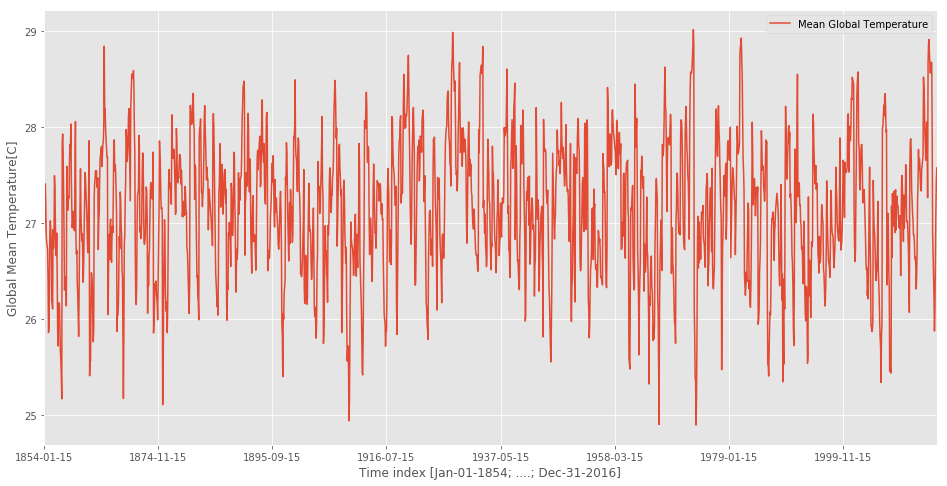

In [42]:
ax = df['Mean Global Temperature'].plot(legend=True, figsize=(16, 8))
ax.set_xlabel("Time index [Jan-01-1854; ....; Dec-31-2016]")
ax.set_ylabel("Global Mean Temperature[C]")
plt.show()

## Compute the monthly means for each month

In [43]:
jan_mean = df.loc[df.index.str.endswith('-01-15')].mean().values[0]
feb_mean = df.loc[df.index.str.endswith('-02-15')].mean().values[0]
march_mean = df.loc[df.index.str.endswith('-03-15')].mean().values[0]
april_mean = df.loc[df.index.str.endswith('-04-15')].mean().values[0]
may_mean = df.loc[df.index.str.endswith('-05-15')].mean().values[0]
june_mean = df.loc[df.index.str.endswith('-06-15')].mean().values[0]
july_mean = df.loc[df.index.str.endswith('-07-15')].mean().values[0]
aug_mean = df.loc[df.index.str.endswith('-08-15')].mean().values[0]
sept_mean = df.loc[df.index.str.endswith('-09-15')].mean().values[0]
oct_mean = df.loc[df.index.str.endswith('-10-15')].mean().values[0]
nov_mean = df.loc[df.index.str.endswith('-11-15')].mean().values[0]
dec_mean = df.loc[df.index.str.endswith('-12-15')].mean().values[0]

In [44]:
list_of_months_means = [jan_mean, feb_mean, march_mean,april_mean, may_mean,
                        june_mean, july_mean, aug_mean, sept_mean, oct_mean,
                        nov_mean, dec_mean]

In [45]:
# add the computed meas to our dataframe 
# we have 12 values for months in a year. we need to duplicate this
# list 163 times to for the 163 years from 1854 through 2016
df['Monthly mean'] = list_of_months_means * 163

In [46]:
df.head(10)

,Mean Global Temperature,Monthly mean
1854-01-15,26.653449,27.158809
1854-02-15,26.942350,27.168412
1854-03-15,27.250400,27.197664
1854-04-15,27.410539,27.170535
1854-05-15,27.199303,27.160715
1854-06-15,26.885991,27.143973
1854-07-15,26.801505,27.152428
1854-08-15,26.764260,27.137910
1854-09-15,26.727095,27.123789
1854-10-15,26.425251,27.112768


## Compute the anomalies by finding the row-wise difference

In [47]:
df['Anomalies'] = df['Mean Global Temperature'] - df['Monthly mean']
df.head()

,Mean Global Temperature,Monthly mean,Anomalies
1854-01-15,26.653449,27.158809,-0.505360
1854-02-15,26.942350,27.168412,-0.226062
1854-03-15,27.250400,27.197664,0.052737
1854-04-15,27.410539,27.170535,0.240004
1854-05-15,27.199303,27.160715,0.038588


## Compute the 3 month running mean for the anomalies

In [48]:
df["3 month Running Mean"] = df['Anomalies'].rolling(window=3, 
                                         min_periods=1, 
                                         center=True).mean()

In [49]:
df.head()

,Mean Global Temperature,Monthly mean,Anomalies,3 month Running Mean
1854-01-15,26.653449,27.158809,-0.505360,-0.365711
1854-02-15,26.942350,27.168412,-0.226062,-0.226229
1854-03-15,27.250400,27.197664,0.052737,0.022226
1854-04-15,27.410539,27.170535,0.240004,0.110443
1854-05-15,27.199303,27.160715,0.038588,0.006870


In [50]:
df.describe()

,Mean Global Temperature,Monthly mean,Anomalies,3 month Running Mean
count,1956.000000,1956.000000,1.956000e+03,1956.000000
mean,27.149119,27.149119,4.540789e-17,0.000010
std,0.703123,0.023183,7.027403e-01,0.644288
min,24.898468,27.112768,-2.265853e+00,-1.994452
25%,26.675081,27.134380,-4.641893e-01,-0.420812
50%,27.179462,27.148200,2.981553e-02,0.019144
75%,27.647833,27.162639,4.971040e-01,0.457446
max,29.016496,27.197664,1.864068e+00,1.766289


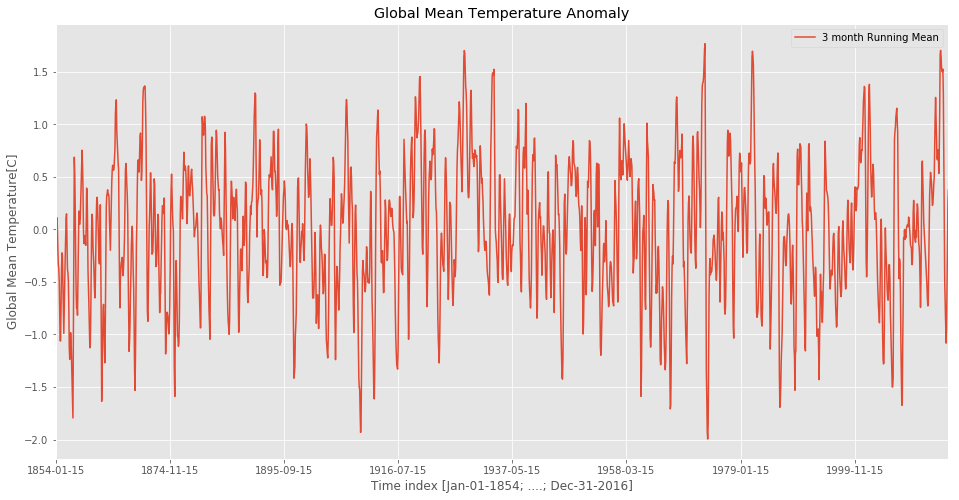

In [51]:
ax = df['3 month Running Mean'].plot(legend=True, figsize=(16, 8))
ax.set_xlabel("Time index [Jan-01-1854; ....; Dec-31-2016]")
ax.set_ylabel("Global Mean Temperature[C]")
ax.set_title("Global Mean Temperature Anomaly")
plt.show()

[back to top](#Table-of-Contents)